In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import RandomizedPCA
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

sns.set()

## 5.9 专题：主成分分析
`主成分分析`(principal component analysis，PCA)是应用最广的无监督算法之一。虽然`PCA`是一种非常基础的降维算法，但它仍然是一个非常有用的工具，尤其适用于数据可视化、噪音过滤、特征抽取和特征工程等领域。

### 5.9.1 主成分分析简介
`主成分分析`是一个快速灵活的数据降维无监督方法。

下面通过一个包含200个数据点的二维数据集演示该算法的操作(`图5-80`)：

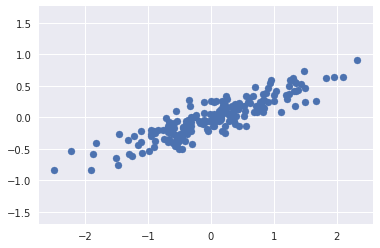

In [7]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

`x`变量和`y`变量显然具有线性关系，这使我们回想起`5.6`节介绍的线性回归数据。但是这里的问题稍有不同：回归分析是根据`x`值预测`y`值，而无监督学习希望探索`x`值和`y`值之间的相关性。

在主成分分析中，一种量化两变量间关系的方法是在数据中找到一组主轴，并用这些主轴来描述数据集。利用`Scikit-Learn`的`PCA`评估器，可以进行如下计算：

In [8]:
pca = PCA(n_components=2) 
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

该拟合从数据中学习到了一些指标，其中最重要的是`成分`和`可解释差异`：

In [10]:
pca.components_

array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

In [11]:
pca.explained_variance_

array([ 0.7625315,  0.0184779])

为了查看这些数字的含义，在数据图上将这些指标以向量形式画出来，用`成分`定义向量的方向，将`可解释差异`作为向量的平方长度(`图5-81`)：

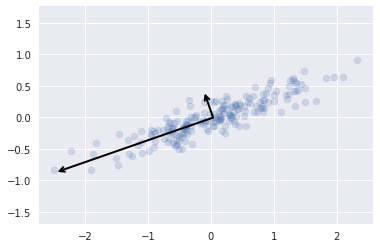

In [16]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca() 
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0) 
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# 画出数据 
plt.scatter(X[:, 0], X[:, 1], alpha=0.2) 

for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v) 

plt.axis('equal')
plt.show()

这些向量表示数据主轴，箭头长度表示输入数据中各个轴的`重要程度`，更准确地说，它衡量了数据投影到主轴上的方差的大小。每个数据点在主轴上的投影就是数据的`主成分`。

如果将原始数据和这些主成分都画出来，将得到如`图5-82`：

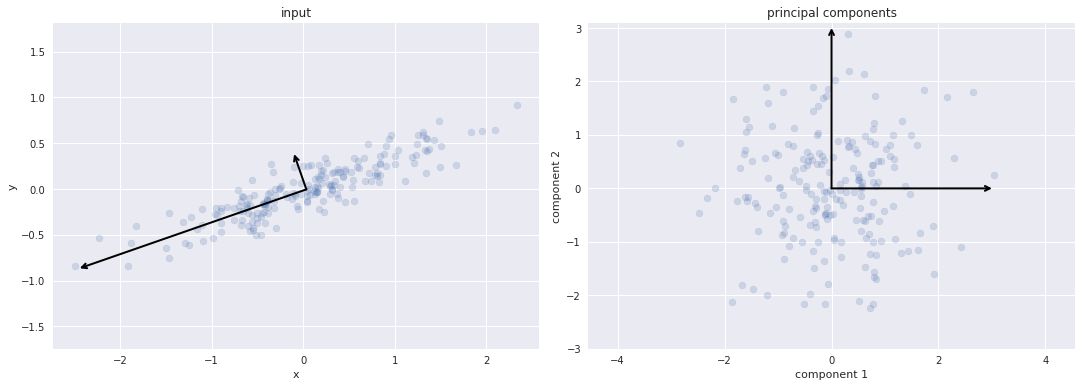

In [17]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2', 
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

plt.show()

这种从数据的坐标轴变换到主轴的变换是一个仿射变换，仿射变换包含`平移`(translation)、`旋转`(rotation)和`均匀缩放`(uniform scaling)三个步骤。

主成分分析在现实的机器学习和数据探索中有着非常广泛的应用。

#### 5.9.1.1 用PCA降维
用`PCA`降维意味着去除一个或多个最小主成分，从而得到一个更低维度且保留最大数据方差的数据投影。例如：

In [18]:
pca = PCA(n_components=1)

pca.fit(X) 
X_pca = pca.transform(X) 
print("original shape: ", X.shape) 
print("transformed shape:", X_pca.shape)

original shape:  (200, 2)
transformed shape: (200, 1)


变换的数据被投影到一个单一维度。为了理解降维的效果，我们来进行数据降维的逆变换，并且与原始数据一起画出(`图5-83`)：

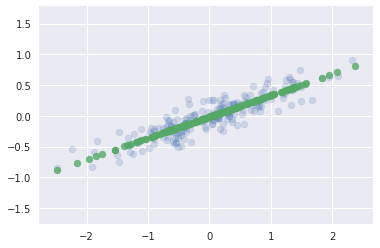

In [19]:
X_new = pca.inverse_transform(X_pca)

plt.scatter(X[:, 0], X[:, 1], alpha=0.2) 
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8) 
plt.axis('equal')
plt.show()

浅色的点是原始数据，深色的点是投影的版本。可以清楚地看到`PCA`降维的含义：沿着最不重要的主轴的信息都被去除了，仅留下了含有最高方差值的数据成分。被去除的那一小部分方差值(与主轴上分布的点成比例，如`图5-83` 所示)基本可以看成是数据在降维后损失的`信息`量。

这种降维后的数据集在某种程度上足以体现数据中最主要的关系：虽然有`50%`的数据维度被削减，但数据的总体关系仍然被大致保留了下来。

#### 5.9.1.2 用PCA作数据可视化：手写数字
在仅有两个维度时`PCA`的作用可能不明显，但是当维度很高时，它的价值就有所体现了。

我们将`PCA`用于手写数字数据的应用：

In [23]:
digits = load_digits() 

# 从64维投影至二维
pca = PCA(2) 
projected = pca.fit_transform(digits.data) 
print(digits.data.shape) 
print(projected.shape)

(1797, 64)
(1797, 2)


画出每个点的前两个主成分(`图5-84`)：

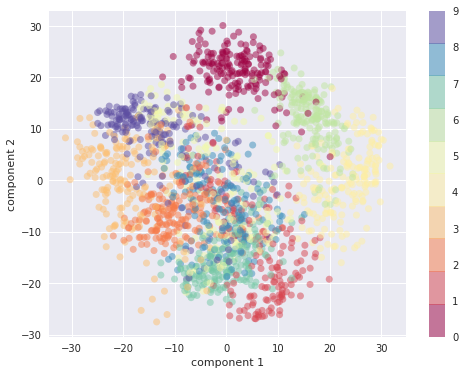

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(projected[:, 0], projected[:, 1], c=digits.target, edgecolor='none', 
            alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10)) 
plt.xlabel('component 1') 
plt.ylabel('component 2')
plt.colorbar()
plt.show()

整个数据是一个64维的点云，而且这些点还是每个数据点沿着最大方差方向的投影。我们找到了在64维空间中最优的延伸和旋转方案，使得我们可以看到这些点在二维平面的布局。上述工作都是以无监督的方式进行的。

#### 5.9.1.3 成分的含义
我们可以进一步提出问题：削减的维度有什么含义？可以从基向量的组合角度来理解这个问题。例如，训练集中的每幅图像都是由一组64像素值的集合定义的，将称其为向量$x$：
+ $x = [x_1, x_2, x_3, ..., x_{64}]$

我们可以用像素的概念来理解。也就是说，为了构建一幅图像，将向量的每个元素与对应描述的像素(单位列向量)相乘，然后将这些结果加和就是这副图像：
+ $image(x)= x_1\cdot(pixel\sim 1) + x_2\cdot(pixel\sim 2) + x_3\cdot(pixel\sim 3), ... , x_{64}\cdot(pixel\sim {64})$

我们可以将数据的降维理解为删除绝大部分元素，仅保留少量元素的`基向量`(basis vector)。例如，如果仅使用前8个像素，我们会得到数据的8维投影(`图5-85`)，但是它并不能反映整幅图像，因为我们丢掉了几乎`90%`的像素信息：
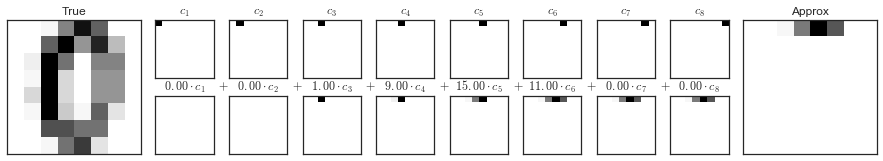

面板的上面一行是单独的像素信息，下面一行是这些像素值的累加，累加值最终构成这幅图像。如果仅使用`8`个像素成分，就仅能构建这个`64`像素图像的一小部分。只有使用该序列和全部的`64`像素，才能恢复原始图像。

逐像素表示方法并不是选择基向量的唯一方式。我们也可以使用其他基函数，这些基函数包含预定义的每个像素的贡献，如下所示：
+ $image(x) = mean + x_1\cdot(basis\sim 1) + x_2 \cdot (basis\sim 2) + x_3 \cdot (basis\sim 3) ...$

`PCA`可以被认为是选择最优基函数的过程，这样将这些基函数中前几个加起来就足以重构数据集中的大部分元素。用低维形式表现数据的主成分，其实就是与序列每一个元素相乘的系数。`图5-86`是用均值加上前`8`个`PCA`基函数重构数字的效果：
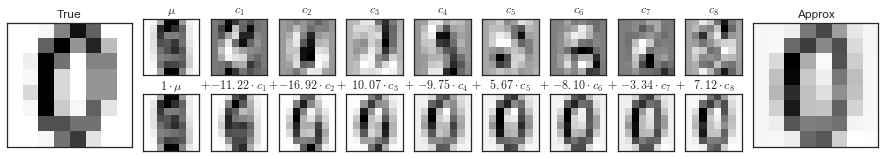

与像素基不同，`PCA`基可以通过为一个均值加上`8`个成分来恢复输入图像最显著的特征。每个成分中像素的数量必然是二维数据示例中向量的方向。这就是`PCA`提供数据的低维表示的原理：它发现一组比原始的像素基向量更能有效表示输入数据的基函数。

#### 5.9.1.4 选择成分的数量
在实际使用`PCA`的过程中，正确估计用于描述数据的成分的数量是非常重要的环节。我们可以将累计方差贡献率看作是关于成分数量的函数，从而确定所需成分的数量(`图5-87`)：

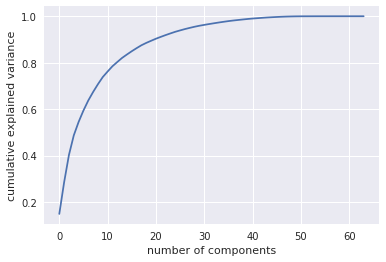

In [32]:
pca = PCA().fit(digits.data)

plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance')
plt.show()

这个曲线量化了在前`N`个主成份中包含了多少总的`64`维的方差。可以看到前`10`个成分包含了`75%`的方差。二维的投影会损失很多信息，我们需要大约`20`个成分来保持`90%`的方差。

### 5.9.2 用 PCA 作噪音过滤
`PCA`也可以被用作噪音数据的过滤方法，任何成分的方差都远大于噪音的方差，所以相比于噪音，成分应该相对不受影响。

用手写数字数据看看如何实现噪音过滤。首先画出几个无噪音的输入数据(`图5-88`)：

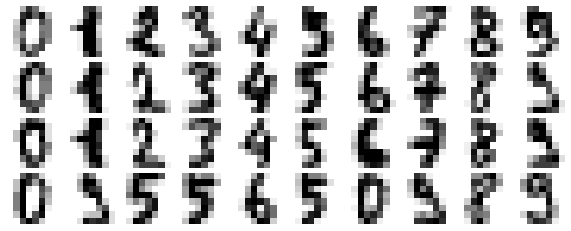

In [35]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4), 
                             subplot_kw={'xticks':[], 'yticks':[]}, 
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))

    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8), cmap='binary', interpolation='nearest', 
                  clim=(0, 16)) 

plot_digits(digits.data)
plt.show()

现在添加一些随机噪音(`图5-89`)：

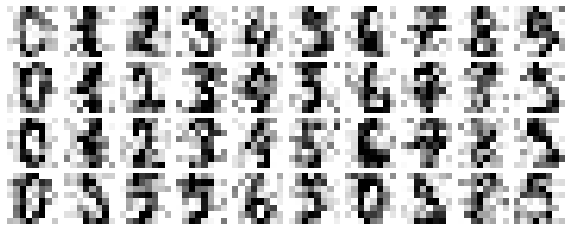

In [36]:
np.random.seed(42)

noisy = np.random.normal(digits.data, 4) 
plot_digits(noisy)
plt.show()

用噪音数据训练一个`PCA`，要求投影后保存`50%`的方差：

In [37]:
pca = PCA(0.50).fit(noisy) 
pca.n_components_

12

`50%`的方差对应`12`个主成份。现在来计算出这些成分，然后利用逆变换重构过滤后的手写数字(`图5-90`)：

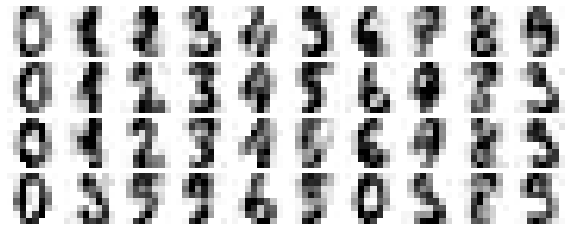

In [38]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components) 
plot_digits(filtered)
plt.show()

`信号保留/噪音过滤`的性质使`PCA`成为一种非常有用的特征选择方式。与其在很高维的数据上训练分类器，你可以选择在一个低维表示中训练分类器，该分类器将自动过滤输入数据中的随机噪音。

### 5.9.3 案例：特征脸
`Wild`数据集带标签的人脸数据：

In [40]:
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


因为这是一个非常大的数据集，所以我们利用`RandomizedPCA`，它包含了一个随机方法来估计前`N`个主成分，比标准的`PCA`评估器速度更快，特别适用于高维数据(这里的维度将近3000)。来看看前`150`个成分：

In [42]:
pca = RandomizedPCA(150)
pca.fit(faces.data)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


RandomizedPCA(copy=True, iterated_power=2, n_components=150,
       random_state=None, whiten=False)

将这个例子中带有前面几个主成分的图像可视化是非常有趣的(这些成分被称作`特征向量`，因此这些图像的类型通常被称作`特征脸`)：

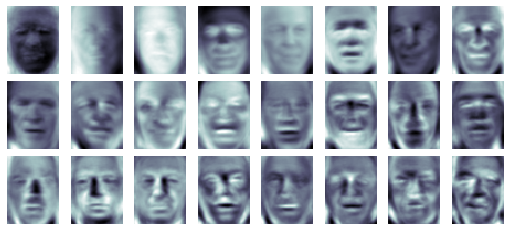

In [43]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),

subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1)) 
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

plt.show()

结果非常有趣。让我们先来观察一下图像之间的不同：前面几张特征脸(从左上角开始)看起来和照向脸的光线角度有关，而后面的主向量似乎是挑选出了特定的特征，例如眼睛、鼻子和嘴唇。来看看这些成分的累计方差，以及该投影保留了多少数据信息(`图5-92`)：

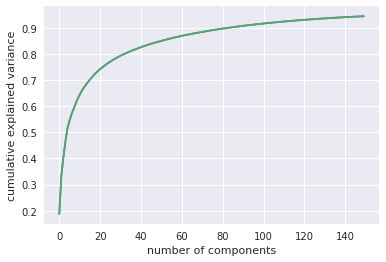

In [45]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance')
plt.show()

这`150`个成分包含了`90%`的方差。这使我们相信，利用这`150`个成分可以恢复数据的大部分必要特征。比较输入图像和利用这`150`个成分重构的图像(`图5-93`)：

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


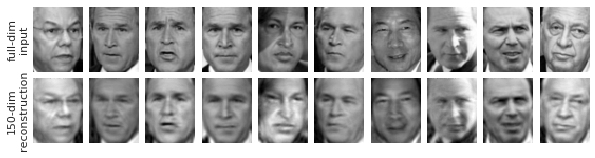

In [46]:
# 计算成分和投影的人脸
pca = RandomizedPCA(150).fit(faces.data) 
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

# 画出结果

fig, ax = plt.subplots(2, 10, figsize=(10, 2.5), 
                       subplot_kw={'xticks':[], 'yticks':[]}, 
                       gridspec_kw=dict(hspace=0.1, wspace=0.1)) 

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    ax[0, 0].set_ylabel('full-dim\ninput') 
    ax[1, 0].set_ylabel('150-dim\nreconstruction')

plt.show()

上面一行是输入图像，而下面一行是从大约`3000`个原始特征中精选出的`50`个特征重构的图像。这个可视化结果清楚地展示了`PCA`特征选择的作用：虽然它将数据的原始维度信息缩减了将近`20`倍，但是投影数据还是包含了足够的信息，使我们可以通过肉眼识别出图像中的人物。

这说明我们的分类算法只需要在`150`维的数据上训练，而不需要在`3000`维的数据上训练。维度的选择取决于选定的算法，而选择合适的算法会带来更有效的分类效果。

### 5.9.4 主成分分析总结
`PCA`用途广泛、可解释性强，可以有效应用于大量情景和学科中。 对于任意高维的数据集，我倾向于以PCA分析开始，可视化点间的关系，理解数据中的主要方差，理解固有的维度(通过画出解释方差比)。 当然，`PCA`并不是一个对每个高维数据集都有效的算法，但是它提供了一条直接且有效的路径，来获得对高维数据的洞察。

经常受数据集的异常点影响是`PCA`的主要弱点。因为这个理由，很多效果更好的`PCA`变体被开发出来，这些`PCA`变体方法迭代执行，丢弃对原始成分描述得很糟糕的数据点。`Scikit-Learn`中有一些有趣的`PCA`变体，包括`RandomizedPCA`和`SparsePCA`。`RandomizedPCA`算法使用了一个非确定方法，快速地近似计算出一个维度非常高的数据的前几个主成分，`SparsePCA`引入了一个正则项来保证成分的稀疏性。